In [ ]:
# ! pip install --user --upgrade scipy numba
# ! pip install --user psutil

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed

from trees import TransferTreeRegressor, build_tree, Node
from simulation import generate_data, split_out_dat
from criteria import mse, transfer, causal_tree_criterion


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 3]

In [4]:
from trees import Leaf
leaf = Leaf(0,0,0,0)

def plot_split(node, X, tau, context_idxs):
    idx = X[:, node.dim] > node.thresh
    d = np.vstack([tau, idx, context_idxs]).T
    df = pd.DataFrame(d, columns = ['tau', 'split', 'ctx'])

    for _, d in df.groupby('split'):
        v = d.groupby('ctx').mean().tau.values
        print(d.groupby('ctx').mean().tau.values)
    # sns.distplot(df)
    g = sns.FacetGrid(df, row = 'split', hue = 'ctx', aspect=5.0)
    g.map(sns.distplot, 'tau', bins=10, kde=False)
    plt.legend()

In [5]:
from sklearn.metrics import mean_squared_error
from numba import njit


def fit_models(phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target):
    causal_model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              max_depth = 3, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    causal_model.fit(phi_source, 
                     ys_source, 
                     treatment=treatment,
                     min_samples=25,
                     var_weight=0.5)

    # causal_model.set_best_tree()
    causal_model.tree = causal_model.tree_path[0][1]

    transfer_model = TransferTreeRegressor(criterion = transfer,
                              max_depth = 3, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    transfer_model.fit(phi_source, 
                       ys_source, 
                       treatment=treatment,
                       context_idxs=context_idxs, 
                       target_X=phi_target,
                       min_samples=25,
                       mean_weight=0.,
                       var_weight=0.0,
                       tau_var_weight=0.0,
                       cross_exp_weight=1.0,
                       importance=False)

    # transfer_model.set_best_tree()
    # transfer_model.tree
    transfer_model.tree = transfer_model.tree_path[0][1]

    tpreds = transfer_model.predict(phi_target, 0.95)
    cpreds = causal_model.predict(phi_target, 0.95)

    return (mean_squared_error(taus_target, tpreds[:, 0]), mean_squared_error(taus_target, cpreds[:, 0])), (tpreds, cpreds), (transfer_model, causal_model), (phi_source, phi_target, taus_source, taus_target, context_idxs)
    

In [8]:
# Y := f(H, W, X, Z, N_Y)
# Y := f(W, X, Z, N_Y)
def fn(h, v, z, w):
    val = -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0])
    return val


v_conds = [(-0.5,0,1), (1,1,.5), (0.5,2,1), (-1,2,1)]
# v_conds = [(0.5,0,1)]*4

hiddens = [(0,2)]*4
# hiddens = [(0, 2), (2, 1), (3, 2), (4, 1)]

z_conds = [(2,2), (4,2), (6,2), (0,2)]
# z_conds = [(2,2), (4,2), (6,2), (2,2)]


def runrun(N):
    dat = generate_data(N,
                        fn, 
                        hidden_cause = True, 
                        plot = False, 
                        hiddens = hiddens,
                        v_conds = v_conds, 
                        z_conds = z_conds)

    return fit_models(*split_out_dat(dat))

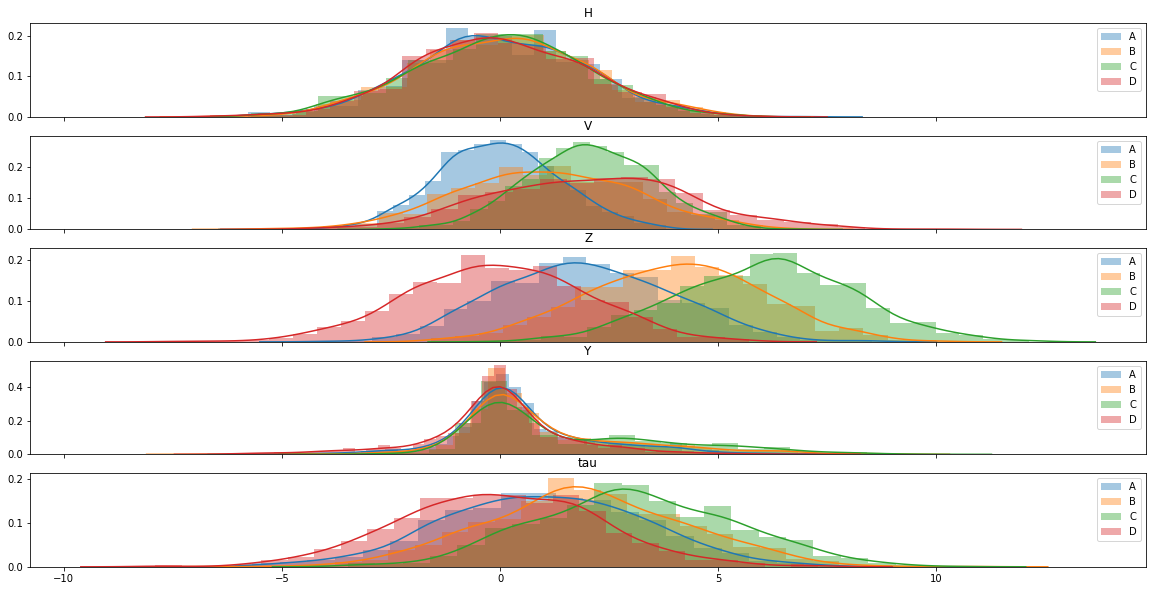

In [9]:
dat = generate_data(1000,
                    fn, 
                    hidden_cause = True, 
                    plot = True, 
                    hiddens = hiddens,
                    v_conds = v_conds, 
                    z_conds = z_conds)


In [10]:
ys, Xs, taus = zip(*dat)
phi_source, phi_target, _, _, _, taus_source, taus_target = split_out_dat(dat)

from sklearn.linear_model import LinearRegression

# LinearRegression().fit(Xs[0], ys[0]).coef_, LinearRegression().fit(Xs[1], ys[1]).coef_, LinearRegression().fit(Xs[2], ys[2]).coef_, LinearRegression().fit(Xs[3], ys[3]).coef_

for d in [LinearRegression().fit(Xs[i], taus[i]).coef_ for i in range(4)]:
    print(d)

[0.00406922 0.97417013 0.52038018]
[-0.01990157 -0.93530069  0.50745546]
[ 0.00383107 -0.93778395  0.48085044]
[-0.02903692  0.76491921  0.50387651]


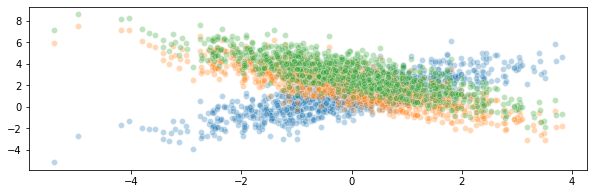

In [11]:
for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(3)]:
    sns.scatterplot(Xs[0][:, 1], d, alpha=0.3)

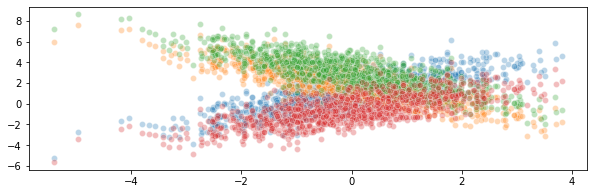

In [12]:
for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(4)]:
    sns.scatterplot(Xs[0][:, 1], d, alpha=0.3)

In [13]:
a = np.random.random(10)
b = np.random.random(5)

(a - np.mean(a))

array([ 0.15579708, -0.22009857,  0.46317496, -0.07943403,  0.51616854,
        0.30365615, -0.39261177, -0.43353573, -0.314969  ,  0.00185236])

In [25]:
scores, preds, models, datt = runrun(1000)
tt, ct = models

In [26]:
tt.tree

|--dim: 1, thresh: 4.0209 scores: -1.885 || 4.301 || 0.016 || 0.539 || 3.770, gain: 0.5882, tot_gain: 0.8816 
   |--dim: 1, thresh: 0.3794 scores: -0.335 || 1.501 || 0.028 || 0.141 || 1.370, gain: -0.0004, tot_gain: 0.0211 
      |--dim: 1, thresh: -0.5721 scores: 0.003 || 0.217 || 0.178 || 0.090 || -0.088, gain: -0.0060, tot_gain: -0.0060 
         |--pred: -0.1919, scores: 0.000 || 0.037 || 0.321 || 0.011 || -0.025, N: 48 
         |--pred: 0.8385, scores: 0.009 || 0.703 || 0.295 || 0.407 || -0.401, N: 67 
      |--dim: 1, thresh: 3.2067 scores: -0.338 || 1.765 || 0.032 || 0.152 || 1.639, gain: 0.0275, tot_gain: 0.0275 
         |--pred: 1.0281, scores: -0.140 || 1.057 || 0.044 || 0.052 || 0.997, N: 420 
         |--pred: 1.9089, scores: -0.225 || 3.644 || 0.106 || 0.226 || 3.416, N: 198 
   |--dim: 0, thresh: 3.8622 scores: -2.139 || 8.506 || 0.026 || 0.124 || 8.365, gain: 0.2047, tot_gain: 0.2723 
      |--dim: 1, thresh: 6.6802 scores: -2.352 || 10.157 || 0.024 || 0.147 || 9.937, 

In [27]:
ct.tree

|--dim: 1, thresh: 3.2067 scores: -2.143 || 4.301 || 0.016, gain: 0.3176, tot_gain: 0.7247 
   |--dim: 1, thresh: 0.3794 scores: -0.149 || 0.870 || 0.035, gain: -0.0055, tot_gain: 0.0200 
      |--dim: 0, thresh: -0.0767 scores: -0.002 || 0.217 || 0.178, gain: 0.0080, tot_gain: 0.0080 
         |--pred: -0.3106, scores: 0.004 || 0.096 || 0.350, N: 53 
         |--pred: 0.9802, scores: -0.014 || 0.961 || 0.286, N: 62 
      |--dim: 0, thresh: 2.7959 scores: -0.142 || 1.057 || 0.044, gain: 0.0175, tot_gain: 0.0175 
         |--pred: 1.1692, scores: -0.166 || 1.367 || 0.046, N: 376 
         |--pred: -0.1779, scores: 0.006 || 0.032 || 0.450, N: 44 
   |--dim: 0, thresh: 2.5646 scores: -2.312 || 7.208 || 0.022, gain: 0.2827, tot_gain: 0.3871 
      |--dim: 1, thresh: 6.6364 scores: -2.508 || 10.429 || 0.024, gain: 0.0701, tot_gain: 0.0701 
         |--pred: 2.8415, scores: -1.483 || 8.074 || 0.029, N: 553 
         |--pred: 4.4046, scores: -1.095 || 19.400 || 0.082, N: 170 
      |--dim: 1

In [28]:
# dim 0 should be ignored!

imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

imp(tt, ct)

0.1642479469006637

In [29]:
ts, cs = scores
(ts - cs)/cs

-0.18318666997241928

0.1720788018768828
-0.1612166940070829
CPU times: user 377 ms, sys: 4.01 ms, total: 381 ms
Wall time: 379 ms


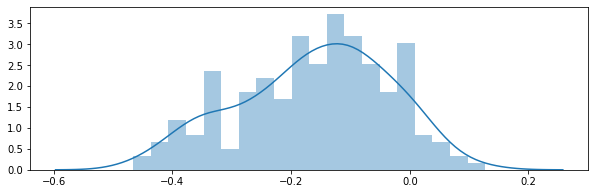

In [37]:
%%time
# N = 1000
# 0.18, -0.16
imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

results = Parallel(n_jobs=-1)(delayed(runrun)(1000) for i in range(200))
mse = [(t-c)/c for (t,c),_,(tt, ct),_ in results]
importances = [imp(tt, ct) for (t,c),_,(tt, ct),_ in results]
print(np.mean(importances))
print(np.mean(mse))
sns.distplot(np.array(mse), bins = 20)

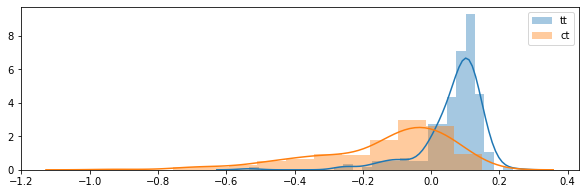

In [38]:
tau_var = [np.mean((np.mean(txx) - txx)**2) for _,_,_,(_,_,_,txx,_) in results]
t_mse, c_mse = zip(*[(t,c) for (t,c),_,(tt, ct),_ in results])
for lbl,d in zip(['tt', 'ct'], [[1-a/b for a,b in zip(t_mse, tau_var)], [1-a/b for a,b in zip(c_mse, tau_var)]]):
    sns.distplot(d, label=lbl)
plt.legend()

In [40]:
# 0.06, -0.14

np.mean(np.array([[1-a/b for a,b in zip(t_mse, tau_var)], [1-a/b for a,b in zip(c_mse, tau_var)]]), 1)

array([ 0.06444949, -0.13969976])

In [41]:
def compare_cis(results):
    taus = [txx for _,_,_,(_,_,_,txx,_) in results]
    tp, cp = zip(*[preds for _,preds,_,_ in results])

    tis = [get_within_ci(d,t) for d,t in zip(tp, taus)]
    cps = [get_within_ci(d,t) for d,t in zip(cp, taus)]

    return tis, cps


def get_within_ci(preds, taus):
    return pd.DataFrame(preds, columns = ['pred', 'lower', 'upper']) \
             .assign(true = taus) \
             .groupby('pred') \
             .apply(lambda df: df.assign(true_cate = df.true.mean())) \
             .pipe(lambda df: df.assign(within_int = (df.true_cate <= df.upper) & (df.true_cate >= df.lower))) \
             .pipe(lambda df: df['within_int'].sum() / df.shape[0])

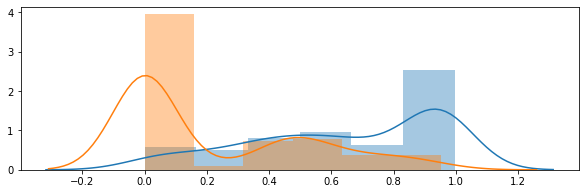

In [42]:
for a in compare_cis(results):
    sns.distplot(a)

In [45]:
# .68, 0.20

np.mean(compare_cis(results)[0]), np.mean(compare_cis(results)[1])

(0.6463599999999999, 0.21834499999999998)

# Causal Tree Test

In [18]:
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def make_nested_grid(params):
    return ParameterGrid({ key: list(ParameterGrid(value))
                           for key, value in params.items()})


def _crossval_score(model, X, y, treatment, weights, splitter, fit_params, init_params):
    model = deepcopy(model)
    model.set_params(**init_params)
    scores = []

    for train_idx, test_idx in splitter.split(X, treatment):
        model.fit(X[train_idx, :], 
                  y[train_idx], 
                  treatment = treatment[train_idx], 
                  sample_weight = weights[train_idx],
                  **fit_params)

        score = model.score(X[test_idx, :],
                            y[test_idx], 
                            treatment = treatment[test_idx], 
                            sample_weight = weights[test_idx],
                            **fit_params)
            
        scores.append(score)
    
    return np.mean(scores)

from joblib import Parallel, delayed

def model_search(model, X, y, treatment, weights, init_params, fit_params, splitter, n_jobs = -1):
    grid = make_nested_grid({'fit_params': fit_params, 
                             'init_params': init_params})

    all_scores = Parallel(n_jobs=n_jobs)(delayed(_crossval_score)(model, X, y, treatment, weights, splitter, **g) for g in grid)
    # all_scores = [_crossval_score(model, X, y, treatment, weights, splitter, **g) for g in grid]

    return list(zip(grid, all_scores))   

In [20]:
def eta(X):
    return 0.5 * X[:, 0] + X[:, 1]

def kappa(X):
    return 0.5 * X[:, 0]

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01)

N = 1000
S = round(N/2)
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
y = gen_y(X, treatment)

In [48]:
def eta(X):
    return 0.5 * np.sum(X[:, :2], axis=1) + np.sum(X[:, 2:], axis=1)

def kappa(X):
    return np.sum(X[:, :2] * (X[:, :2] > 0).astype(int), axis=1)

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01, size = X.shape[0])


N = 12000
S = 1000
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
weights = np.ones(N)
y = gen_y(X, treatment)

In [49]:
sim_dat = pd.concat([pd.DataFrame(X, columns = range(1, 7)), 
                     pd.DataFrame({ 'y': y, 'treatment': treatment, 'tau': kappa(X)})], axis=1)

sim_dat.to_csv('sim_dat-2.csv', index=False)

In [43]:
# idx = np.arange(X.shape[0])
# np.random.shuffle(idx)

# treatment = treatment[idx]
# X = X[idx, :]
# y = y[idx]

In [50]:
%%time

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 3)

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 4,
                              alpha = 0.1, 
                              honest = False)

fit_params = {'min_samples': [25] }
init_params = {'alpha': [ -.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.4 ], 'honest': [True] }

results = model_search(model, X[:S], y[:S], treatment[:S], weights[:S], init_params, fit_params, cv)

best_params = sorted(results, key = lambda t: t[1])[0][0]['init_params']

best_params

CPU times: user 23.8 ms, sys: 8.13 ms, total: 31.9 ms
Wall time: 378 ms


{'alpha': 0.0, 'honest': True}

In [56]:
from sklearn.metrics import r2_score

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 50,
                              alpha = 0.1, 
                              honest = False)

# model.set_params(**best_params)
model.set_params(alpha = -100.0, honest=True)

model.fit(X[:S], y[:S], treatment=treatment[:S], min_samples=25, var_weight = 0.5)

print(r2_score(kappa(X[S:]), model.predict(X[S:])))

model.tree

0.25306848861537323


|--dim: 1, thresh: 0.3194 scores: -0.422 || 0.931 || 0.087, gain: 0.1567, tot_gain: 0.1760 
   |--dim: 0, thresh: -0.3486 scores: -0.006 || 0.163 || 0.144, gain: 0.0530, tot_gain: 0.0080 
      |--pred: -0.2550, scores: 0.029 || 0.065 || 0.348, N: 103 
      |--dim: 4, thresh: 0.0986 scores: -0.088 || 0.651 || 0.209, gain: -0.0451, tot_gain: -0.0451 
         |--pred: 0.9389, scores: -0.058 || 0.881 || 0.291, N: 99 
         |--pred: 0.4186, scores: 0.016 || 0.175 || 0.332, N: 100 
   |--dim: 4, thresh: 0.3878 scores: -0.573 || 3.090 || 0.197, gain: 0.0320, tot_gain: 0.0113 
      |--dim: 3, thresh: 0.0808 scores: -0.432 || 3.489 || 0.266, gain: -0.0207, tot_gain: -0.0207 
         |--pred: 1.8345, scores: -0.224 || 3.365 || 0.452, N: 77 
         |--pred: 1.9028, scores: -0.187 || 3.621 || 0.344, N: 57 
      |--pred: 1.7472, scores: -0.173 || 3.053 || 0.350, N: 64 

In [28]:
preds = pd.DataFrame(model.predict(X[S:], interval = 0.975), columns = ['pred', 'lower', 'upper'])

preds.assign(true = kappa(X[S:])) \
    .groupby('pred') \
    .apply(lambda df: df.assign(true_cate = df.true.mean())) \
    .pipe(lambda df: df.assign(within_int = (df.true_cate <= df.upper) & (df.true_cate >= df.lower))) \
    .pipe(lambda df: df['within_int'].sum() / df.shape[0])

0.7431

In [ ]:
model = TransferTreeRegressor(criterion = mse, max_depth = 5, min_samples_leaf = 10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
# np.mean((preds - y)**2)

np.histogram(preds)

In [60]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
np.mean((preds - y)**2)

(array([  15,    0,   41,   23,   95,   47,   87,  103,  406, 1183]),
 array([-129.40835129, -116.21549089, -103.02263049,  -89.82977009,
         -76.63690969,  -63.44404929,  -50.25118889,  -37.05832849,
         -23.86546809,  -10.67260769,    2.52025272]))

In [34]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [35]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [36]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.7473, 32.487 , 11.613 ,  4.5725])

In [37]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([12.42759, 25.75614,  5.67631,  3.50874])

In [38]:
model = TransferTreeRegressor(criterion=mse, max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [39]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [52]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.3818, 32.1958, 11.2033,  3.5604])

In [51]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([10.9098,  4.9235,  3.2745,  3.7268])

In [42]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 1, use_weights = None, model_search = False)

[0.3605, 21.2762, 16.201, 7.1304]

In [31]:
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True)

[0.4141, 20.8479, 0.2354, 6.2956]

In [32]:
run_model(dat, model, phi, 0, 1, use_weights = 1, model_search = False)

[12.3876, 41.752, 16.8672, 4.4122]

In [33]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True)

[11.362, 31.8239, 11.2857, 4.7136]

In [1802]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 